# Uncertainty for a Synthetic Regression Task using probly

This notebook gives an example for quantifying uncertainty in a synthetic regression setting using the setup from Valdenegro-Toro et al. (2022). Paper: https://arxiv.org/abs/2204.09308

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

### Generate Synthetic Data
Generate a synthetic data set based on a sinusoidal function. Sample data points (x) uniformly between 0 and 10 and generate labels based on the function. Create training data, test data and out of distribution data (x between 10 and 15).

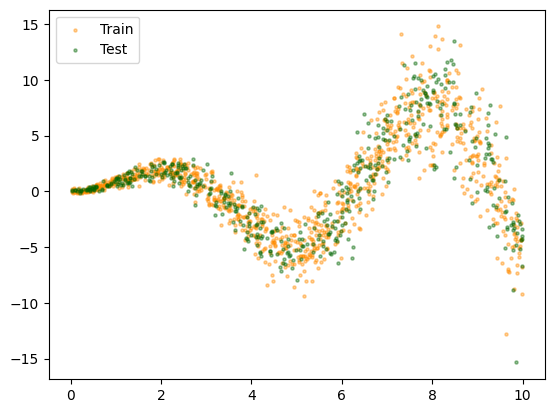

In [2]:
def toy_function(x, remove_noise=False):
    """Sigmoidal function to generate synthetic data.

    Args:
        x: numpy.ndarray, input data
        remove_noise: bool, whether to have noise in the function outcome or not
    Returns:
        numpy.ndarray, output data
    """
    eps1 = np.random.normal(0, 0.3, x.shape)
    eps2 = np.random.normal(0, 0.1, x.shape)
    if remove_noise:
        eps1 = np.mean(eps1)
        eps2 = np.mean(eps2)
    return x * np.sin(x) + eps1 * x + eps2


# Generate data points between 0 and 10
X = np.expand_dims(np.random.uniform(0, 10, 1500), axis=1)
X_train = X[:1000]
X_test = X[1000:]

# Generate ood data points between 10 and 15
X_ood = np.expand_dims(np.random.uniform(10, 15, 200), axis=1)

# Generate labels
y = toy_function(X)
y_train = y[:1000, 0]
y_test = y[1000:, 0]

# Sort test/ood samples for easy plotting
id_test = np.argsort(X_test[:, 0])
id_ood = np.argsort(X_ood[:, 0])
X_test, y_test, X_ood = X_test[id_test], y_test[id_test], X_ood[id_ood]

# create data loaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
    ),
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
    ),
    batch_size=batch_size,
    shuffle=False,
)

# plot data
plt.scatter(X_train[:, 0], y_train, c="darkorange", s=5, alpha=0.4, label="Train")
plt.scatter(X_test[:, 0], y_test, c="darkgreen", s=5, alpha=0.4, label="Test")
plt.legend()
plt.show()

### Create Dropout Model
Create a simple neural network and transform it to a Dropout model using probly.

In [3]:
from probly.representation import Dropout


class Net(nn.Module):
    """Simple Neural Network class with two heads.

    Attributes:
        fc1: nn.Module, first fully connected layer
        fc2: nn.Module, second fully connected layer
        fc31: nn.Module, fully connected layer of first head
        fc32: nn.Module, fully connected layer of second head
    """

    def __init__(self):
        """Initialize an instance of the Net class."""
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc31 = nn.Linear(32, 1)

        self.fc32 = nn.Linear(32, 1)
        self.act = nn.ReLU()

    def forward(self, x):
        """Forward pass of the neural network.

        Args:
            x: torch.Tensor, input data
        Returns:
            torch.Tensor, output data
        """
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mu = self.fc31(x)
        sigma2 = F.softplus(self.fc32(x))
        x = torch.cat([mu, sigma2], dim=1)
        return x


net = Net()
# transform model to a Dropout model
model = Dropout(net, p=0.25)
optimizer = optim.Adam(model.parameters())  # , lr=0.001)


# criterion = nn.GaussianNLLLoss()


class GaussianNLL(nn.Module):
    """Implementation of the Gaussian negative log-likelihood loss."""

    def __init__(self):
        """Initialize an instance of the GaussianNLL class."""
        super().__init__()

    def forward(self, mu, sigma2, y):
        """Forward pass of the Gaussian negative log-likelihood loss.

        Args:
            mu: torch.Tensor, predicted mean
            sigma2: torch.Tensor, predicted variance
            y: torch.Tensor, target labels
        """
        return 0.5 * torch.mean(torch.log(sigma2) + (y - mu) ** 2 / sigma2)


criterion = GaussianNLL()

### Train Dropout Model
Train the Dropout model based on the training data, the given loss (criterion) and optimizer.

In [4]:
epochs = 700

pbar = tqdm(range(epochs), desc="Training", unit="epoch")
for _ in pbar:
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, 1)
        mean = outputs[:, 0, 0]
        var = outputs[:, 0, 1]
        loss = criterion(mean, var, targets)
        loss.backward()
        optimizer.step()
    pbar.set_description(desc=f"Loss: {loss:.4f} Progress")
model.eval()

Loss: 1.7382 Progress: 100%|██████████| 700/700 [00:10<00:00, 66.62epoch/s] 


### Evaluation
Evaluate model performance and uncertainty behavior for the test and ood data points.

In [5]:
from probly.quantification.regression import (
    expected_conditional_variance,
    total_variance,
    variance_conditional_expectation,
)

# generate prediction
y_pred = model(torch.from_numpy(X_test).float(), 100).detach().cpu().numpy()
y_pred_ood = model(torch.from_numpy(X_ood).float(), 100).detach().cpu().numpy()

# evaluate model performance
mse = ((y_pred.mean(axis=1)[:, 0] - y_test) ** 2).mean()
print(f"MSE: {mse:.2f}")

# quantify uncertainty
tu = total_variance(y_pred)
au = expected_conditional_variance(y_pred)
eu = variance_conditional_expectation(y_pred)
tu_ood = total_variance(y_pred_ood)
au_ood = expected_conditional_variance(y_pred_ood)
eu_ood = variance_conditional_expectation(y_pred_ood)

MSE: 12.30


In [ ]:
# plot uncertainty
plot_x = np.concatenate((X_test, X_ood), axis=0)[
    2:, 0
]  # cut off first two values to increase smoothness
plot_y = np.concatenate((y_pred.mean(axis=1), y_pred_ood.mean(axis=1)), axis=0)[2:, 0]
plot_tu = np.concatenate((tu, tu_ood), axis=0)[2:]
plot_au = np.concatenate((au, au_ood), axis=0)[2:]
plot_eu = np.concatenate((eu, eu_ood), axis=0)[2:]
plt.plot(X_test, toy_function(X_test, remove_noise=True), label="Ground truth", c="k")
plt.scatter(plot_x, plot_y, c="darkblue", label="Mean Prediction", s=1, zorder=10)
plt.fill_between(
    plot_x,
    plot_y - (plot_tu / 2),
    plot_y + (plot_tu / 2),
    alpha=0.2,
    color="darkgreen",
    label="Total Uncertainty",
)
plt.fill_between(
    plot_x,
    plot_y - (plot_au / 2),
    plot_y + (plot_au / 2),
    alpha=0.2,
    color="darkred",
    label="Aleatoric Uncertainty",
)
plt.fill_between(
    plot_x,
    plot_y - (plot_eu / 2),
    plot_y + (plot_eu / 2),
    alpha=0.2,
    color="darkgoldenrod",
    label="Epistemic Uncertainty",
)
plt.ylim([-20, 20])
plt.legend()
plt.show()